# Goal

The purpose of this tutorial is to get you acquainted with medical image formats and several useful Python packages to manipulate medical images. We assume that you have some familiarity with Python and its syntax. If not, we suggest that you first take a look at [this website](urltobedecided). 

The packages we'll primarily use in the tutorial are
- [NumPy](https://numpy.org/). You cannot avoid this package if you want to use matrices, linear algebra, computing, etc.
- [Matplotlib](https://matplotlib.org/). This package allows you to make plots and visualize images. 
- [SimpleITK](https://simpleitk.org/). While there are many Python packages that will let you read a medical image or apply some functions to the image, none of them have the versatility that SimpleITK has. This is because it is based on ITK (Insight ToolKit), one of the oldest and most widely used image processing toolkits. 
- [PyTorch](https://pytorch.org/). PyTorch is one of the primary Python packages used for deep learning. It has all kinds of nice features that make it (relatively) easy to design and train a neural network. 
- [MONAI](https://monai.io/). MONAI is a PyTorch extension that is specifically designed for developing deep learning methods on medical images.

First, let's install the required packages that are not by default in your Python distribution.

In [ ]:
# !pip install SimpleITK
# !pip install monai

# Part 1: Loading a medical image

Medical image file formats are plenty. Most medical imaging devices store images in DICOM format, but you will also see Nifti, MetaImage (MHD), or NRRD files. 

What many image formats have in common is that they contain *meta information*. This is information about, e.g., the physical size of a pixel or voxel in the image, the origin of the image in world coordinates, a rotation matrix to correct for patient orientation, and even information about the CT/MRI scanner that is used and its settings. We're typically not interested in all this information or *tags*, but some of it is indispensable for image analysis. 

Here, you will try to 

- Load the provided images (NOTE: let's see what makes sense, I think small Nifti images)
- Extract their physical voxel size
- Convert the image to a NumPy Array
- Visualize the image (NOTE: for this we will need to use something like Matplotlib)

In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import torch

# Part 2: Image properties

Get the voxel spacing in mm, origin ...

Scale the image *using SimpleITK or scipy ndimage*?

# Part 3: Visualizing an image
 
 Matplotlib imshow: belangrijk: wat is de x-as en de y-as en de richting daarvan?

# Part 4: Applying a filter

You will now apply a filter.
What kind of filter makes sense here? Filtering is only discussed in Lecture 2? Maybe just a rotation or translation or something?

> Question: What happens ..

Compute distance transforms?



Transform between world and pixel coordinates and back

Apply a median filter to denoise an image

Apply a Gaussian filter for denoising

Compare results

# Part 4: PyTorch
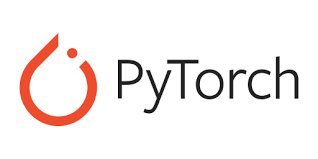
[PyTorch](https://pytorch.org/) is (along with TensorFlow) one of the two most commonly used Python libraries for deep learning. In this part of the tutorial, we will define a very simple optimization problem and how to tackle it with PyTorch. In the next part of the tutorial, we will use MONAI, which is a PyTorch extension for medical images.


# Part 5: MONAI

![MONAI](https://monai.io/assets/img/MONAI-logo_color_full.png)

Medical Open Network for Artificial Intelligence ([MONAI](https://monai.io/)) is the library we use for deep learning on medical images. The 'raw' loaded medical images are often not directly suited for training a neural network; they need to be processed before being used. MONAI offers a streamlined framework for transforming the data and feeding it into the network. MONAI is built on the same concepts as PyTorch, but has specific functions and models that make it appropriate for medical images. In practice, you will use a combination of the two. A typical workflow in both PyTorch and MONAI is as follows:
1. Define a dataset
2. Define transforms on the dataset to make it suitable for the network
3. Build a dataloader
4. Build the network / define the optimizer, loss function and hyperparameters
5. Start training procedure

Schematically, this looks like this

<img src="https://www.oreilly.com/library/view/deep-learning-with/9781789534092/assets/e03c0f94-a8ed-42fe-96a0-1eb2956445be.png" width=600></img> 

In this tutorial, we build a classification network for tumor classification, using the camelyon patch dataset. This is a dataset consisting of 96x96 colored pixel 2D images. Each image has a binary label, telling if the image contains a tumor or not.

## Part 5a: Dataset
The first step in the procedure consists of building a dataset that contains the images and labels. First, download the dataset from [here](https://github.com/basveeling/pcam) and unzip it into the /data/raw directory. **(@jelmer: die losse .h5 bestanden staan nog compressed in .gz formaat. Eventueel kan ik de map met alles geextract wel zippen en op canvas zetten ofzo)**
A dataset is an object, that we build using the pytorch Dataset template. To build a custom dataset, we need to define three functions in the dataset:
- __init__: runs when constructing the object, place where you can construct paths to the data and save them in an array, or load the images in an array.
- __len__: returns length of the dataset, i.e. number of samples
- __getitem__: returns a sample from the dataset. This function takes an index as input. (in our case an image and its corresponding binary label). Sometimes this function returns a dictionary containing image and label.

In this section, we will build a dataset for the train, validation and test data.

In [2]:
import h5py
import os
from monai.data import CacheDataset
# path

class CamelyonData(CacheDataset):
    
    def __init__(self, path, mode='train', transform=None):
        # runs once when constructing the dataset
        # start with loading data from the .h5 files
        h5X = h5py.File(os.path.join(path, f'camelyonpatch_level_2_split_{mode}_x.h5'), 'r')
        h5y = h5py.File(os.path.join(path, f'camelyonpatch_level_2_split_{mode}_y.h5'), 'r')
        # store in numpy arrays
        self.x = np.array(h5X.get('x'))
        self.x = np.swapaxes(self.x, 1,-1)
        self.y = np.array(h5y.get('y'))
        self.transform = transform
        
    def __getitem__(self, index):
        # self.x is a numpy array with dimensions [N, 96, 96, 3] (contains the images)
        # self.y is a numpy array with dimensions [N, 1, 1, 1] (contains the labels)
        # Finish the dataset by constructing the getitem function and len function.
        # Make getitem return a dictionary with keys ['img', 'label'] for the image and label respectively
        if self.transform:
            self.x, = self.transform(self.x)
        # @jelmer dit hieronder gaat dan weg
        return {'img': self.x[index,:,:,:], 'label': self.y[index,0,0,0]}
    
    def __len__(self):
        return self.x.shape[0]

### Transforms and CacheDataset
For construction of our dataset, we make use of the Monai CacheDataset. The dataset takes transforms as an input upon initialization. These transforms are either deterministic (loading images, intensity normalization) or random (random rotation, flips). Transforms can be concatenated using the Compose operator in Monai.

These transforms are executed when you request an item out of the dataset (upon running getitem). The deterministic transforms are the same for each call, whereas the random transforms may differ. Monai's cachedataset stores the deterministic transforms in memory, and only redoes the random transforms, which is more computationally efficient. Therefore, random transforms should be placed as late as possible in the series of transforms.

> Visualize a number of samples from the dataset. What is their corresponding label?

For augmentation of our training set, we want to use a number of transforms that are built-in in Monai. Monai contains numerous [transforms](https://docs.monai.io/en/stable/transforms.html#), there is even the possibility to write your own. 
>Decide which transforms are suitable to use for data augmentation in our classification problem and build a traindataset using these as augmentation.

>Build a validation and test dataset as well.

In [3]:
from monai.transforms import Compose, ToTensor, AddChannel
train_transform = Compose([
    AddChannel(),
    ToTensor()
])
val_transform = Compose([
    AddChannel(),
    ToTensor()
])
test_transform = Compose([
    AddChannel(),
    ToTensor()
])

## Part 5b: Building a dataloader
Now that we have a dataset, we can build a dataloader, that automatically generates batches with given size. As input it uses one of the training sets constructed in the previous section.

>Build a [dataloader](https://docs.monai.io/en/stable/data.html#dataloader) for the train, test and validation set.

In [4]:
from monai.data import DataLoader
d = CamelyonData('data/raw')
trainloader = DataLoader(d, batch_size=5)

## Part 5c: Define the network, hyperparameters and loss function
Now our data pre-processing is all set up, we can define our neural network architecture. We will use a built-in convolutional neural network architecture from Pytorch: __VGG16__, that we will train on our image data.

In [7]:
# Use GPU when available:
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device = "cpu"
print(device)

cpu


In [8]:
from torchvision.models import vgg16
import torch.nn as nn
# after the VGG16 architecture, we stack a linear layer with a single neuron with sigmoid acitivation
# this indicates the binary label

class CamelyonNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # set vgg16 as default network
        self.model = vgg16()
        # change last linear layer from image net classification to binary
        self.model.classifier[-1] = nn.Linear(4096, 1)
        self.softmax = nn.Softmax(dim = -1)
        
    def forward(self, x):
        return self.softmax(self.model(x))

In [9]:
model = CamelyonNetwork().to(device)

To train our network, we should select an optimizer and loss function

> Construct an optimizer for training the network and set a learning rate

> Find a suitable [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and construct it

In [10]:
optimizer = torch.optim.Adam(model.parameters(), 0.001)
loss_function = nn.BCELoss()

## Part 5d: Training procedure for classification

Now we have all the ingredients in place to start training our network. Easiest is to define a train function that performs the training procedure.
Training loops have a typical order:
- Load data from the dataloader
- Input images through the network
- Calculate loss
- Backpropagate loss

> Finish the training function, that should return: loss over training set and test set and trained model. (Hier dan nog een beetje tactisch dingen uit slopen)

In [11]:
from tqdm import tqdm

def train_Camelyon(model, trainloader, epochs, device=device, val_freq=1):
    train_loss, val_loss = list(), list()
    for epoch in tqdm(range(epochs)):
        step = 0; epoch_loss = 0
        for batch in trainloader:
            optimizer.zero_grad()
            imgs = batch['img'].float().to(device)
            GT = batch['label'].float().to(device)
            prediction = model(imgs).squeeze(1)
            loss = loss_function(GT, prediction)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            step += 1
        train_loss.append(epoch_loss/step)
    return train_loss, model
            

In [ ]:
train_Camelyon(model, trainloader, 500)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

## Part 5e: Performance evaluation
Hier iets van een ROC curve of confusion matrix laten maken?